# Quantum Enhanced Auxiliary Field Quantum Monte Carlo 

This work was done in collaboration with the Next Generation Computing team at [BASF](https://www.basf.com/global/en.html). 

In this tutorial we implement a quantum-classical hybrid workflow for computing the ground state energies of a strongly interacting molecular system. The algorithm consists of two parts: 

1. A variational quantum eigensolver that uses the quantum-number-preserving ansatz proposed by [Anselmetti et al. (2021)](https://doi.org/10.1088/1367-2630/ac2cb3) to generate a quantum trial wave function $|\Psi_T\rangle$ using CUDA Quantum. 
2. An Auxiliary-Field Quantum Monte Carlo simulation that realizes a classical imaginary time evolution and collects the ground state energy estimates.


In [1]:
# Package installs and relevant imports.

!pip install pyscf==2.6.0 openfermion==1.6.1 ipie==0.7.1

import cudaq

import numpy as np
import matplotlib.pyplot as plt

from pyscf import gto, scf, ao2mo, mcscf

from openfermion import jordan_wigner, generate_hamiltonian

from src.vqe_cudaq_qnp import VQE, get_cudaq_hamiltonian
from src.utils_ipie import get_coeff_wf, gen_ipie_input_from_pyscf_chk

from ipie.hamiltonians.generic import Generic as HamGeneric
from ipie.qmc.afqmc import AFQMC
from ipie.systems.generic import Generic
from ipie.trial_wavefunction.particle_hole import ParticleHole
from ipie.analysis.extraction import extract_observable

from ipie.config import config

# Ipie has recently added GPU suppoort however this remains a bit tricky to use as it requires manual installation of several packages.
# Once this is streamlined, we can set the GPU option to True in the tutorial.
config.update_option("use_gpu", False)


We start by defining the structure of the molecule, the basis set, and its spin. We build the molecule object with PySCF and run a preliminary Hartree-Fock computation. Here we choose as an example a [chelating agent](https://doi.org/10.1021/acs.jctc.3c01375) representing a relevant class of substances industrially produced at large scales. Their use ranges, among the others, from water softeners in cleaning applications, modulators of redox behaviour in oxidative bleaching, scale suppressants, soil remediation and ligands for catalysts. In particular we focus here in a Fe(III)-NTA complex whose structure is given in the file imported below. 

In [2]:
# Define the molecular structure and the basis set for the Fenta molecule.

atom = "src/geo_fenta.xyz"
basis = "cc-pVTZ"
spin = 1
num_active_orbitals = 5
num_active_electrons = 5

# You can swap to O3 which is a smaller system and takes less computational resources and time to run. 

atom = "src/geo_o3.xyz"
basis = "cc-pVTZ"
spin = 0
num_active_orbitals = 9
num_active_electrons = 12

In [3]:
# PYSCF helps to build the molecule and run Hartree-Fock.

# Define the molecule.
molecule = gto.M(atom=atom, spin=spin, basis=basis, verbose=0)

# Restriced open shell HF.
hartee_fock = scf.ROHF(molecule)  
hartee_fock.chkfile = "src/output.chk" 

# Run Hartree-Fock.
hartee_fock.kernel()

-224.34048064812245

### Hamiltonian preparation for VQE

Since this molecule contains of around 600 orbitals (which would correspond to 1200 qubits) and 143 total electrons, it is impossible to perform a full VQE with full statevector simulation. Therefore, we need to identify an active space with fewer orbitals and electrons that contribute to the strongly interacting part of the whole molecule. We then run a post Hartree-Fock computation with the PySCF's built-in CASCI method in order to obtain the one-body ($t_{pq}$) and two-body 
($V_{prqs}$) integrals that define the molecular Hamiltonian in the active space:

$$ H= \sum_{pq}t_{pq}\hat{a}_{p}^\dagger \hat {a}_{q}+\sum_{pqrs}  V_{prqs}\hat a_{p}^\dagger \hat a_{q}^\dagger \hat a_{s}\hat a_{r} \tag{1}$$

In [4]:
# Run a CASCI simulation for computing the Hamiltonian in the active space.
casci = mcscf.CASCI(hartee_fock, num_active_orbitals, num_active_electrons)
casci.fix_spin_(ss=(molecule.spin / 2 * (molecule.spin / 2 + 1)))


# Executes the kernel to compute the hamiltonian in the active space.
casci.kernel()

# Compute the one-body (h1) and two-body integrals (tbi) as shown in equation 1.
h1, energy_core = casci.get_h1eff()

h2 = casci.get_h2eff()
h2_no_symmetry = ao2mo.restore('1', h2, num_active_orbitals)

# V_pqrs terms in H.
tbi = np.asarray(h2_no_symmetry.transpose(0, 2, 3, 1), order='C')

# Compute the hamiltonian and convert it to a CUDA-Q operator.
mol_ham = generate_hamiltonian(h1, tbi, energy_core.item())
jw_hamiltonian = jordan_wigner(mol_ham)
hamiltonian, constant_term = get_cudaq_hamiltonian(jw_hamiltonian)

### Run VQE with CUDA-Q

We can now execute the VQE algorithm using the quantum number preserving ansatz. At the end of the VQE, we store the final statevector that will be used in the classical AFQMC computation as an initial guess. 

In [5]:
# Define some options for the VQE.
options = {
    'n_vqe_layers': 1,
    'maxiter': 100,
    'energy_core': constant_term,
    'return_final_state_vec': True
}

n_qubits = 2 * num_active_orbitals

vqe = VQE(n_qubits=n_qubits,
        num_active_electrons=num_active_electrons,
        spin=spin,
        options=options)

results = vqe.execute(hamiltonian)

# Best energy from VQE.
optimized_energy = results['energy_optimized']

# Final state vector.
final_state_vector = results["state_vec"]

# Energies during the optimization loop.
vqe_energies = results["callback_energies"]

# Using cudaq optimizer
# Num Params: 16
# Qubits: 18
# N_layers: 1
# Energy after the VQE: -224.39455391873756


### Auxiliary Field Quantum Monte Carlo (AFQMC)

AFQMC is a numerical method for computing relevant properties of strongly interacting molecules. AFQMC is a type of Quantum Monte Carlo method that combines the use of random walks with an auxiliary field to simulate the imaginary-time evolution of a quantum system and drive it to the lowest energy state. This method can provide accurate results for ground-state properties of a wide range of physical systems, including atoms, molecules, and solids. Here we summarize the main features of AFQMC while a detailed introduction to can be found [here](https://www.cond-mat.de/events/correl13/manuscripts/zhang.pdf).  

We consider the electronic Hamiltonian in the second quantization
\begin{equation}
H = {H}_1 + {H}_2 
=\sum_{pq} h_{pq} {a}_{p}^{\dagger} {a}_{q} + \frac{1}{2} \sum_{pqrs} v_{pqrs}{a}_{p}^{\dagger} {a}_r {a}^{\dagger}_{q} {a}_s \tag{2}
\end{equation}
where ${a}_{p}^{\dagger}$ and ${a}_{q}$ are fermionic creation and annihilation operators of orbitals $p$ and $q$, respectively. The terms $h_{pq} $ and 
$v_{pqrs}$ are the matrix elements of the one-body, $H_1$, and two-body, $H_2$, interactions of $H$, respectively. Here, we omit the spin indices for simplicity. 

AFQMC realizes an imaginary time propagation of an initial state (chosen as a Slater determinant) $\ket{\Psi_{I}}$ towards the ground state $\ket{\Psi_0}$ of a given hamiltonian, $H$, with
\begin{equation}
\ket{\Psi_0} \sim\lim_{n \to \infty} \left[ e^{-\Delta\tau H  }  \right]^{n} \ket{\Psi_{I}}
\tag{3}
\end{equation} 
where $\Delta\tau$ is the imaginary time step.

AFQMC relies on decomposing the two-body interactions $H_2$ in terms of sum of squares of one-body operators ${v}_\gamma$ such that the Hamiltonian ${H}$ becomes
\begin{equation}
H = v_0 - \frac{1}{2}\sum_{\gamma=1}^{N_\gamma} {v}_\gamma^2
\tag{4}
\end{equation}
with ${v}_0 = {H}_1 $ and $
{v}_\gamma = i \sum_{pq} L^{\gamma}_{pq} {a}_{p}^{\dagger}{a}_{q}.
$
The $N_\gamma$ matrices $L^{\gamma}_{pq}$ are called Cholesky vectors as they are  obtained via a Cholesky decomposition of the two-body matrix elements 
$v_{pqrs}$ via $v_{pqrs} = \sum_{\gamma=1}^{N_\gamma} L^{\gamma}_{pr} L^{\gamma}_{qs}$.

The imaginary time propagation evolves an ensemble of walkers $\{\phi^{(n)}\}$ (that are Slater determinants) and allows one to access observables of the system. For example, the local energy
\begin{equation}
    \mathcal{E}_{\text{loc}}(\phi^{(n)}) = \frac{\bra{\Psi_\mathrm{T}}H\ket{\phi^{(n)}}}{\braket{\Psi_\mathrm{T}| \phi^{(n)}}}
    \tag{5}
\end{equation}
defined as the mixed expectation value of the Hamiltonian with the trial wave function $\ket{\Psi_\mathrm{T}}$.


The trial wavefunction can be in general a single or a multi-Slater determinant coming from VQE for example. This might help in achieving more accurate ground state energy estimates.



The implementation of AFQMC we use here is from [ipie](https://github.com/JoonhoLee-Group/ipie) that supports both CPUs and GPUs and requires the following steps:
 
1. Preparation of the molecular Hamiltonian by performing the Cholesky decomposition
2. Preparation of the trial state from the VQE wavefunction
3. Executing AFQMC


### Preparation of the molecular Hamiltonian

In [6]:
# AFQMC.

# Generate the input Hamiltonian for ipie from the checkpoint file from pyscf.
ipie_hamiltonian = gen_ipie_input_from_pyscf_chk(hartee_fock.chkfile,
                                                mcscf=True,
                                                chol_cut=1e-5)


h1e, cholesky_vectors, e0 = ipie_hamiltonian


num_basis = cholesky_vectors.shape[1]
num_chol = cholesky_vectors.shape[0]


system = Generic(nelec=molecule.nelec)


afqmc_hamiltonian = HamGeneric(
    np.array([h1e, h1e]),
    cholesky_vectors.transpose((1, 2, 0)).reshape(
        (num_basis * num_basis, num_chol)),
    e0,
)


# Number of electrons in simulation: (12, 12)


### Preparation of the trial wave function

In [7]:
# Build the trial wavefunction from the state vector computed via VQE.
wavefunction = get_coeff_wf(final_state_vector,
                            n_active_elec=num_active_electrons,
                            spin=spin)


trial = ParticleHole(wavefunction,
                    molecule.nelec,
                    num_basis,
                    num_dets_for_props=len(wavefunction[0]),
                    verbose=False)


trial.compute_trial_energy = True
trial.build()
trial.half_rotate(afqmc_hamiltonian)


### Setup of the AFQMC parameters

Here we can choose the input options like the timestep $\Delta\tau$, the total number of walkers `num_walkers` and the total number of AFQMC iterations `num_blocks`.

In [8]:
# Setup the AFQMC parameters.
afqmc_msd = AFQMC.build(molecule.nelec,
                        afqmc_hamiltonian,
                        trial,
                        num_walkers=100,
                        num_steps_per_block=25,
                        num_blocks=10,
                        timestep=0.005,
                        stabilize_freq=5,
                        seed=96264512,
                        pop_control_freq=5,
                        verbose=False)


# Run the AFQMC.
afqmc_msd.run(estimator_filename = 'src/estimates.0.h5')
afqmc_msd.finalise(verbose=False)


# Extract the energies.
qmc_data = extract_observable(afqmc_msd.estimators.filename, "energy")


# random seed is 96264512
            Block                   Weight            WeightFactor            HybridEnergy                  ENumer                  EDenom                  ETotal                  E1Body                  E2Body
                0   1.0000000000000000e+02  1.0000000000000000e+02  0.0000000000000000e+00 -2.2439465244950203e+04  1.0000000000000000e+02 -2.2439465244950202e+02 -3.7639365203867487e+02  1.5199899958917266e+02
                1   4.2257648211202041e+02  1.4118352566146912e+03 -1.1708781723514100e+02 -2.2474961577830902e+04  1.0000000000000000e+02 -2.2474961577830902e+02 -3.7647308225293006e+02  1.5172346647462109e+02
                2   1.0031489973054153e+02  3.8296931512818799e+02 -1.1739814508643387e+02 -2.2490570288678173e+04  9.9999999999999986e+01 -2.2490570288678177e+02 -3.7651499602921865e+02  1.5160929314243688e+02
                3   9.9899124417981398e+01  1.0007710127132816e+02 -1.1733518883940451e+02 -2.2497061024781047e+04  1.000000000000

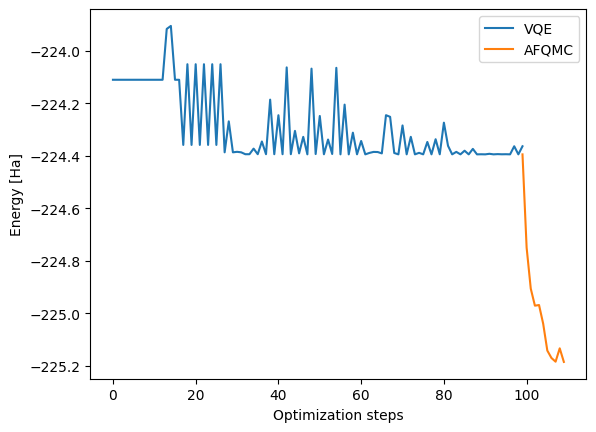

In [9]:
# Plot the energies.

vqe_y = vqe_energies
vqe_x = list(range(len(vqe_y)))
plt.plot(vqe_x, vqe_y, label="VQE")

afqmc_y = list(qmc_data["ETotal"])
afqmc_x = [i + vqe_x[-1] for i in list(range(len(afqmc_y)))]
plt.plot(afqmc_x, afqmc_y, label="AFQMC")

plt.xlabel("Optimization steps")
plt.ylabel("Energy [Ha]")
plt.legend()